In [38]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS
import re
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
# Import data
try:
    data = pd.read_csv("DisneylandReviews.csv", encoding='utf-8')
except UnicodeDecodeError:
    data = pd.read_csv("DisneylandReviews.csv", encoding='latin1')

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


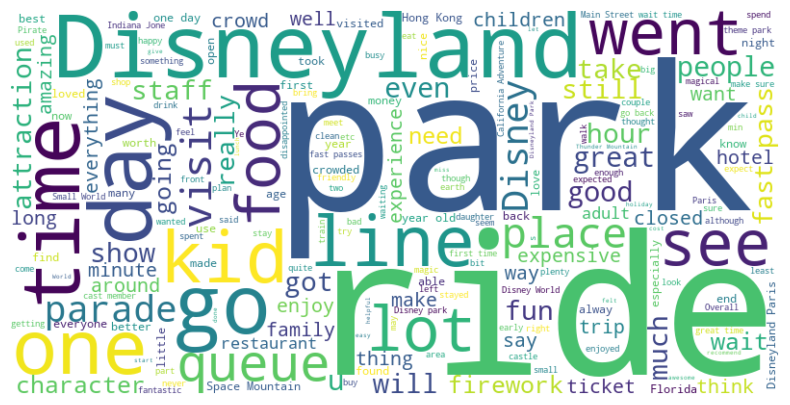

In [15]:
# WordCloud
# Concatenate all reviews into a single string
text_data = ' '.join(review for review in data['Review_Text'] if isinstance(review, str))

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Display the generated word cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.show()

In [34]:
# Preprocess the Review_Text column
data['Review_Text'] = data['Review_Text'].astype(str)

# Join all reviews into a single string
text = " ".join(review for review in data['Review_Text'])

# Remove punctuation
text = re.sub(r'[^\w\s]', '', text)

# Convert text to lowercase
text = text.lower()

# Tokenize the text into words
words = text.split()

# Remove stop words
words = [word for word in words if word not in STOPWORDS]

# Get the frequency of each word in the dataset
word_freq = Counter(words)

# Convert the word frequencies to a DataFrame
word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])

word_freq_df.head(10)

,Word,Frequency
0,youve,614
1,disneyland,32596
2,anywhere,766
3,youll,1129
4,find,3521
5,hong,3321
6,kong,3253
7,similar,687
8,layout,186
9,walk,3494


In [13]:
word_freq_df.to_csv('word_frequencies.csv', index=False)

## Sentiment Analysis

In [35]:
# Initialize the sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

def get_sentiment_score(review):
    if isinstance(review, str):
        return sia.polarity_scores(review)['compound']
    else:
        return 0 

data['Sentiment_Score'] = data['Review_Text'].apply(get_sentiment_score)

In [36]:
data.head(10)

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,Sentiment_Score
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,0.7069
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,0.9901
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,0.9920
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,0.8489
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,0.2846
5,670591897,3,2019-4,Singapore,"Have been to Disney World, Disneyland Anaheim ...",Disneyland_HongKong,0.9653
6,670585330,5,2019-4,India,Great place! Your day will go by and you won't...,Disneyland_HongKong,0.7489
7,670574142,3,2019-3,Malaysia,Think of it as an intro to Disney magic for th...,Disneyland_HongKong,0.7902
8,670571027,2,2019-4,Australia,"Feel so let down with this place,the Disneylan...",Disneyland_HongKong,0.5195
9,670570869,5,2019-3,India,I can go on talking about Disneyland. Whatever...,Disneyland_HongKong,0.9645


In [5]:
# Save the dataframe with the sentiment scores to a new CSV file
data.to_csv('reviews_with_sentiment.csv', index=False)

In [47]:
# Categorize reviews into positive, negative, and neutral based on Sentiment_Score
data['Sentiment_Category'] = pd.cut(data['Sentiment_Score'], bins=[-1, -0.05, 0.05, 1], 
                                    labels=['Negative', 'Neutral', 'Positive'])

# Tokenize and clean the text
stop_words = set(stopwords.words('english') + list(string.punctuation))
def tokenize(text):
    words = word_tokenize(text.lower())
    return [word for word in words if word not in stop_words and word.isalpha()]

data['Tokens'] = data['Review_Text'].apply(tokenize)

# Frequency analysis
freq_positive = Counter()
freq_negative = Counter()
freq_neutral = Counter()

for i in range(len(data)):
    if data.iloc[i]['Sentiment_Category'] == 'Positive':
        freq_positive.update(data.iloc[i]['Tokens'])
    elif data.iloc[i]['Sentiment_Category'] == 'Negative':
        freq_negative.update(data.iloc[i]['Tokens'])
    else:
        freq_neutral.update(data.iloc[i]['Tokens'])

data['Processed_Text'] = data['Tokens'].apply(lambda tokens: ' '.join(tokens))

In [49]:
# Create TF-IDF model
vectorizer = TfidfVectorizer(max_features=1000) 
tfidf_matrix = vectorizer.fit_transform(data['Processed_Text'])

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Get tf-idf scores for each sentiment category
tfidf_positive = tfidf_matrix[data['Sentiment_Category'] == 'Positive'].sum(axis=0).A1  
tfidf_negative = tfidf_matrix[data['Sentiment_Category'] == 'Negative'].sum(axis=0).A1  
tfidf_neutral = tfidf_matrix[data['Sentiment_Category'] == 'Neutral'].sum(axis=0).A1 

# Create DataFrames for each category
df_positive = pd.DataFrame({'Word': feature_names, 'TFIDF': tfidf_positive}).sort_values(by="TFIDF", ascending=False)
df_negative = pd.DataFrame({'Word': feature_names, 'TFIDF': tfidf_negative}).sort_values(by="TFIDF", ascending=False)
df_neutral = pd.DataFrame({'Word': feature_names, 'TFIDF': tfidf_neutral}).sort_values(by="TFIDF", ascending=False)

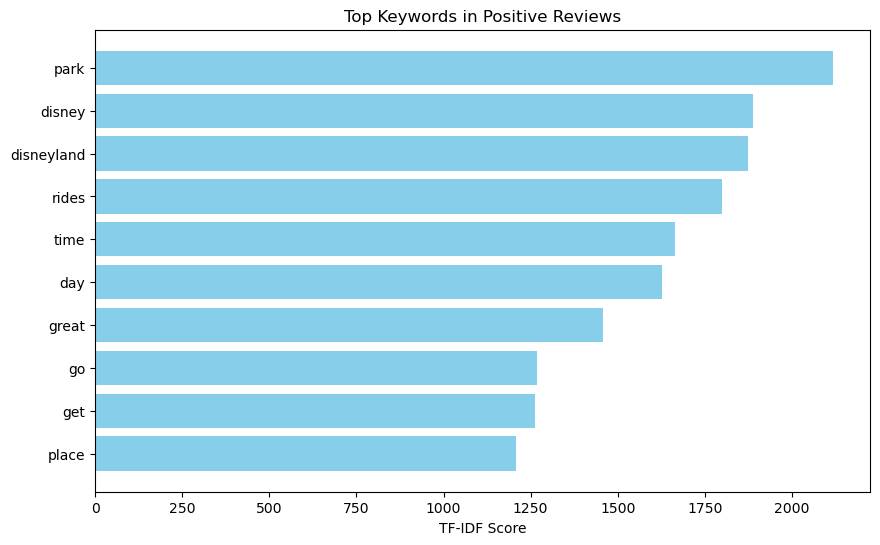

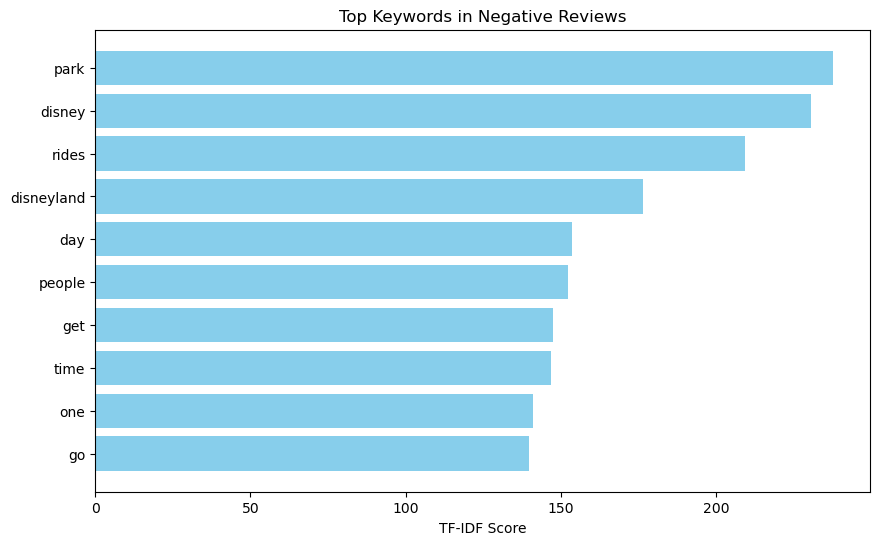

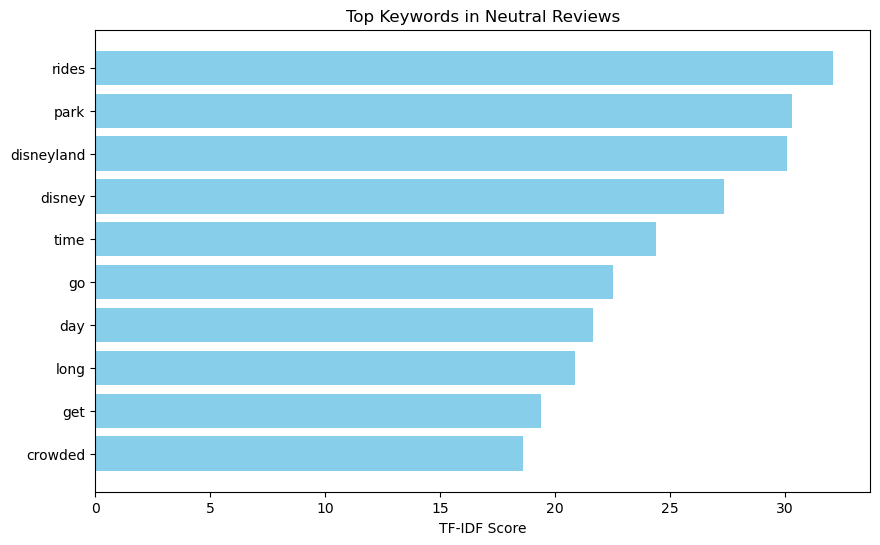

In [51]:
def plot_tfidf_bar_chart(df, title, num_words=10):
    
    # Take the top 'num_words' words
    df_top = df.head(num_words)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(df_top['Word'], df_top['TFIDF'], color='skyblue')
    plt.xlabel('TF-IDF Score')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

plot_tfidf_bar_chart(df_positive, "Top Keywords in Positive Reviews")
plot_tfidf_bar_chart(df_negative, "Top Keywords in Negative Reviews")
plot_tfidf_bar_chart(df_neutral, "Top Keywords in Neutral Reviews")